In [26]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from random import shuffle
from typing import Callable
import cv2
from PIL import Image
from torchsummary import summary
from torchviz import make_dot
plt.style.use("ggplot")

## Data Visualization

In [2]:
# display the content of the chest_xray folder
os.listdir(path="./chest_xray/")

['chest_xray', 'test', 'train', 'val', '__MACOSX']

In [3]:
# general paths of the x-rays data
TRAIN_DIR = "./chest_xray/train/"
VALIDATION_DIR = "./chest_xray/val/"
TEST_DIR = "./chest_xray/test/"

In [4]:
"""All functions will be written in this block"""
def get_number_of_images(path_to_folder:str):
    normal = len(os.listdir(path_to_folder + "NORMAL"))
    pneumonia = len(os.listdir(path_to_folder + "PNEUMONIA"))
    total = normal + pneumonia

    return normal, pneumonia, total

def display_number_samples(set:str, normal:int, pneumonia:int)->None:
    table_data = [
        ["NORMAL", normal],
        ["PNEUMONIA", pneumonia],
        ["TOTAL", normal + pneumonia]
    ]
    
    print(f"{set} set:\n")
    print(tabulate(table_data, headers=["Class", "Number of Samples"], tablefmt="pretty"))
    print("\n")

def plot_normal_pneumonia(normal, pneumonia, subset="whole", ax=None) -> None:
    categories = ["Normal", "Pneumonia"]
    counts = [normal, pneumonia]

    # Creating a bar plot using Seaborn
    sns.barplot(x=categories, y=counts, ax=ax)

    # Adding labels and title to the plot
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title(f'Distribution of Images in the {subset} Set')

    # Displaying the number of instances on the bars
    for i, count in enumerate(counts):
        plt.text(i, count + 10, str(count), ha='center', va='bottom', weight="bold")

    # Displaying the plot
    plt.show()

def plot_examples(path:str, folder="NORMAL/") -> None:
    fig = plt.figure(figsize=(16,5))
    fig.suptitle(f"{folder[:-1]}", size=22)

    img_paths = os.listdir(path+folder)
    shuffle(img_paths) 

    for i, image in enumerate(img_paths[:4]):
        img = cv2.imread(os.path.join(path+folder, image)) 
        plt.subplot(1, 4, i+1, frameon=False)
        plt.imshow(img)
        
    fig.show()

In [5]:
os.listdir(TRAIN_DIR)

['NORMAL', 'PNEUMONIA']

In [6]:
normal_train, pneumonia_train, total_train = get_number_of_images(path_to_folder=TRAIN_DIR)
normal_val, pneumonia_val, total_val = get_number_of_images(path_to_folder=VALIDATION_DIR)
normal_test, pneumonia_test, total_test = get_number_of_images(path_to_folder=TEST_DIR)

In [7]:
display_number_samples(set="TRAIN", normal=normal_train, pneumonia=pneumonia_train)
display_number_samples(set="VALIDATION", normal=normal_val, pneumonia=pneumonia_val)

TRAIN set:

+-----------+-------------------+
|   Class   | Number of Samples |
+-----------+-------------------+
|  NORMAL   |       1341        |
| PNEUMONIA |       3875        |
|   TOTAL   |       5216        |
+-----------+-------------------+


VALIDATION set:

+-----------+-------------------+
|   Class   | Number of Samples |
+-----------+-------------------+
|  NORMAL   |         8         |
| PNEUMONIA |         8         |
|   TOTAL   |        16         |
+-----------+-------------------+




In [8]:
display_number_samples(set="TEST", normal=normal_test, pneumonia=pneumonia_test)

TEST set:

+-----------+-------------------+
|   Class   | Number of Samples |
+-----------+-------------------+
|  NORMAL   |        234        |
| PNEUMONIA |        390        |
|   TOTAL   |        624        |
+-----------+-------------------+




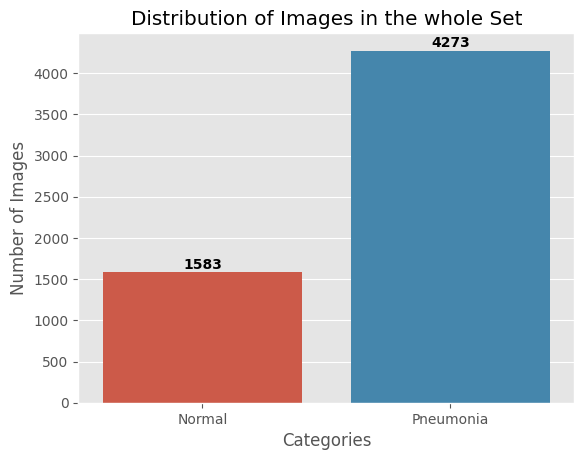

In [9]:
# Plotting the Test subset
plot_normal_pneumonia(normal=normal_test+normal_val+normal_train, 
                      pneumonia=pneumonia_test+pneumonia_val+pneumonia_train)

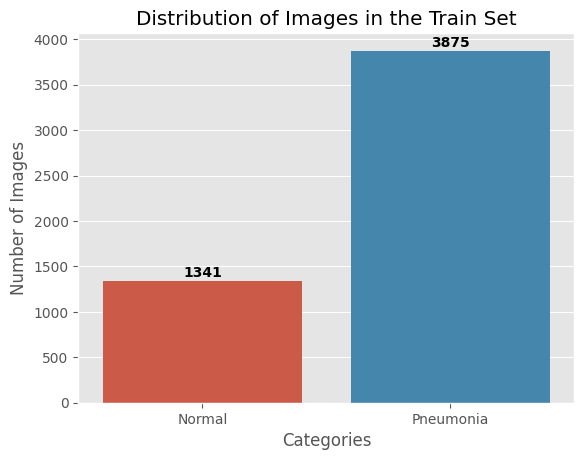

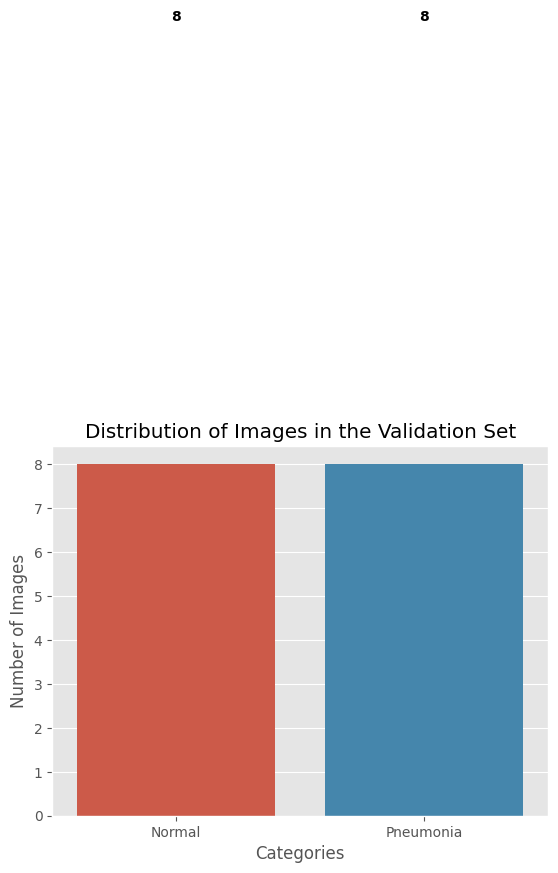

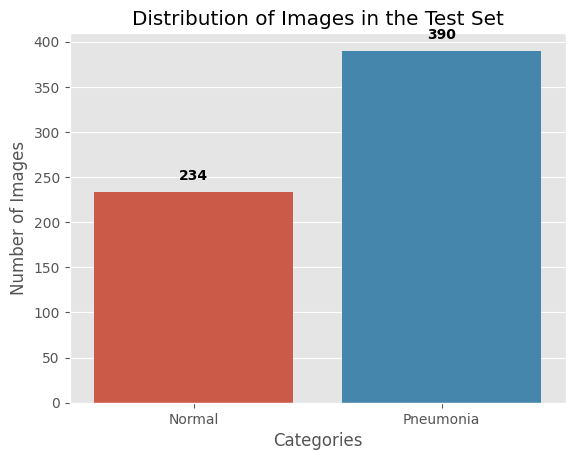

In [10]:
# Plotting the Train subset
plot_normal_pneumonia(normal=normal_train, pneumonia=pneumonia_train, subset="Train")

# Plotting the Validation subset
plot_normal_pneumonia(normal=normal_val, pneumonia=pneumonia_val, subset="Validation")

# Plotting the Test subset
plot_normal_pneumonia(normal=normal_test, pneumonia=pneumonia_test, subset="Test")

C:\Users\azizc\AppData\Local\Temp\ipykernel_26892\833273604.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


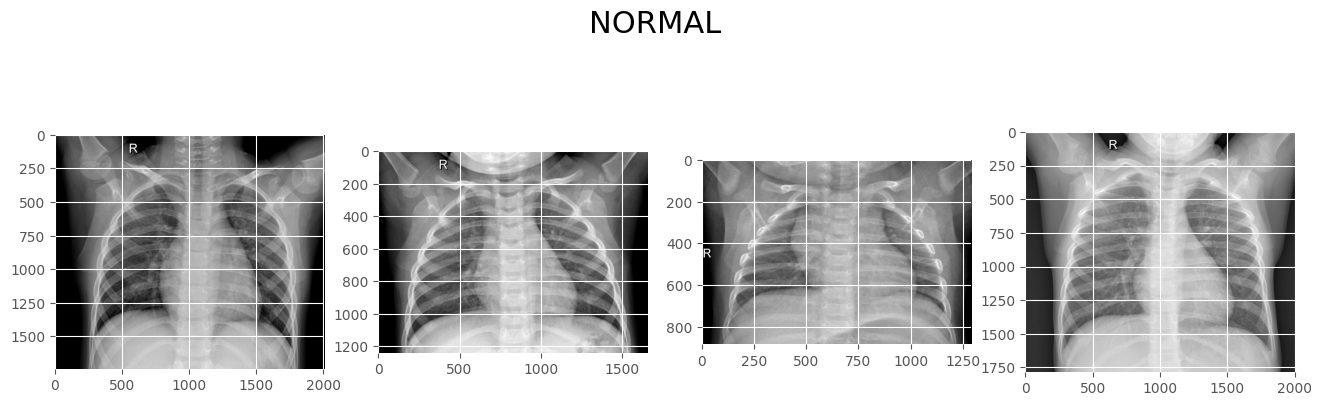

In [11]:
plot_examples(path=TRAIN_DIR)

C:\Users\azizc\AppData\Local\Temp\ipykernel_26892\833273604.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


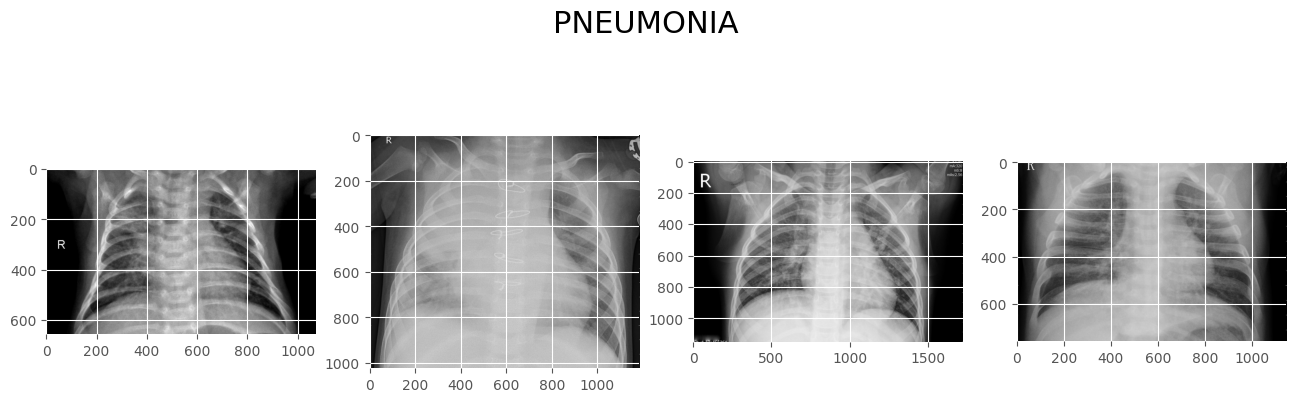

In [12]:
plot_examples(path=TRAIN_DIR, folder="PNEUMONIA/")

In [13]:
train_images_normal = os.listdir(path=TRAIN_DIR+"NORMAL/")
train_images_pneumonia = os.listdir(path=TRAIN_DIR+"PNEUMONIA/")
train_images_total = train_images_normal + train_images_pneumonia

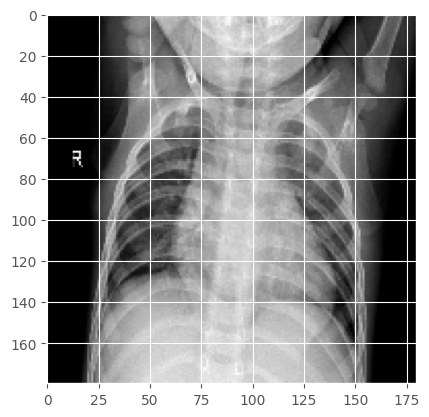

In [14]:
IMAGE_SIZE = 180
img = cv2.imread(TRAIN_DIR+"NORMAL/"+train_images_normal[60])
resized_img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
plt.imshow(resized_img)
plt.show()

In [15]:
resized_img.shape

(180, 180, 3)

In [16]:
transform = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)), #resize image
    transforms.ToTensor() # Convert image to tensor
])

In [17]:
pil_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
transformed_image = transform(img=pil_img)

In [18]:
transformed_image.shape

torch.Size([3, 180, 180])

In [19]:
"""All functions for preprocessing the data"""
# The function can be re-written in a way that it returns a dictionary of transformations in which each key is a unique transformation name string and the value is the transformation itself -> Future ToDo
def transform_img_size(path:str, new_size:int):
    load_img = cv2.imread(filename=path)

    transform = transforms.Compose([
    transforms.Resize(size=(new_size, new_size)), #resize image
    transforms.ToTensor() # Convert image to tensor
    ])
    
    pil_img = Image.fromarray(cv2.cvtColor(load_img, cv2.COLOR_BGR2RGB))
    transformed_image = transform(img=pil_img)

    return transformed_image    #tensor

def transform_img_v1(path:str, new_size:int):
    load_img = cv2.imread(filename=path)

    transform = transform.Compose([
        transforms.RandomRotation(30),  # Randomly rotate images in the range (degrees, 0 to 180)
        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally
        transforms.RandomVerticalFlip(),  # Randomly flip images vertically
        transforms.Resize(size=(new_size, new_size)), #resize image
        #transforms.RandomResizedCrop(size=(new_size, new_size)),  # Randomly crop and resize images
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),  # Randomly adjust brightness, contrast, and saturation
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
    ])

    pil_img = Image.fromarray(cv2.cvtColor(load_img, cv2.COLOR_BGR2RGB))
    transformed_image = transform(img=pil_img)

    return transformed_image

def load_transformed_dataset(data_dir:str, fct_transform: Callable):
    return ImageFolder(root=data_dir, transform=fct_transform)

In [20]:
new_img = transform_img_size(path=TRAIN_DIR+"NORMAL/"+train_images_normal[60],
                   new_size=180)

In [21]:
new_img.shape

torch.Size([3, 180, 180])

In [22]:
training_root_normal = TRAIN_DIR
train_data_transformed = ImageFolder(root=training_root_normal)

In [23]:
train_data_transformed

Dataset ImageFolder
    Number of datapoints: 5216
    Root location: ./chest_xray/train/

In [25]:
from CustomCNN import CNNModel

model = CNNModel(num_classes=10)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
Total params: 5,088
Trainable params: 5,088
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.42
Params size (MB): 0.02
Estimated Total Size (MB): 0.45
----------------------------------------------------------------


In [27]:
# Create a random input tensor
input_tensor = torch.randn(1, 3, 32, 32)

# Generate the computational graph
graph = make_dot(model(input_tensor), params=dict(model.named_parameters()))

# Save the graph as an image file
graph.render("cnn_model_graph", format="png")

# Display the graph
graph.view()

ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH